## Installing keras efficientnets package

In [1]:
!pip install keras-efficientnets

## Importing all dependencies

In [2]:
import keras
import keras.backend as K
import cv2
import random
import tensorflow as tf
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
import matplotlib.pyplot as plt
from keras_efficientnets import EfficientNetB0
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Mounting google Drive

In [3]:
drive.mount('/content/gdrive')


TypeError: ignored

In [ ]:
model = EfficientNetB0(
    include_top=False,
    input_shape=(512 ,512 ,3) ,
    weights = 'imagenet' ,
    dropout_rate = 0.4
)

In [ ]:
model.summary()

## Building model

In [ ]:
def predict(y):
    return model.predict(y)
def preprocess(y):
    return ((y/255)-0.5)*2
x = keras.layers.Input((512 ,512 ,3))
x_ = keras.layers.Input((512 ,512 ,1))
multiply = keras.layers.Multiply()([x ,x_])
#pre = keras.layers.Lambda(preprocess)(multiply)
final = model(multiply)
conv1 = keras.layers.Conv2D(512 ,kernel_size = (2 ,2) ,strides = 2 ,kernel_initializer='glorot_uniform' ,activation = 'relu')(final)
drop1 = keras.layers.Dropout(0.4)(conv1)
conv2 = keras.layers.Conv2D(512 ,kernel_size = (3 ,3) ,kernel_initializer='glorot_uniform' ,activation = 'relu' ,name = 'pen_ultimate')(drop1)
pool1 = keras.layers.MaxPooling2D((6 ,6))(conv2)
flatten1 = keras.layers.Flatten()(pool1)
drop2 = keras.layers.Dropout(0.4)(flatten1)
dense1 = keras.layers.Dense(512 ,activation = 'relu')(drop2)
dense1 = keras.layers.Dense(1 ,activation = 'sigmoid' ,name = 'final')(dense1)
classifier = keras.models.Model(inputs = [x ,x_],outputs = dense1)
classifier.summary()

## Importing the preprocess image arrays and respective masks

In [ ]:
X = np.load('/content/gdrive/My Drive/JPGCT/small_data/.NPY/X_preprocess.npy')
masks = 1 -np.load('/content/gdrive/My Drive/JPGCT/small_data/.NPY/masks.npy')
#X = np.load('/content/gdrive/My Drive/JPGCT/X.npy')
Y = np.load('/content/gdrive/My Drive/JPGCT/small_data/.NPY/Y.npy')
val_X = np.load('/content/gdrive/My Drive/JPGCT/small_data/.NPY/val_X_preprocess.npy')
val_masks = 1 - np.load('/content/gdrive/My Drive/JPGCT/small_data/.NPY/val_masks.npy')
val_Y = np.load('/content/gdrive/My Drive/JPGCT/small_data/.NPY/val_Y.npy')

## Conveting the masks to binary masks

In [ ]:
print('max : {} min : {}'.format(masks.max() ,masks.min()))
masks[masks<0.5] = 0
masks[masks>=0.5] = 1
print('max:{} min:{}'.format(masks.max() ,masks.min()))
val_masks[val_masks<0.5] = 0
val_masks[val_masks>=0.5] = 1


max : 1.0 min : 1.3113021850585938e-06
max:1.0 min:0.0


In [ ]:
masks.shape

(684, 512, 512, 1)

## Visualizing the images and their respective masks

In [ ]:
i = random.choice([k for k in range(X.shape[0])])
print('prediction is {}'.format(Y[i]))
img = (((X[i ,: ,: ,:]/2)+0.5)*255).astype('uint8')
fig ,(ax1 ,ax2 ,ax3) = plt.subplots(1 ,3,fig_size = (10,10))
ax1.imshow(img.astype('uint8'))
ax2.imshow(masks[i].reshape((512 ,512)))
img_ = X[i ,: ,: ,:]*(masks[i])
img_ = ((img_/2)+0.5)*255
ax3.imshow(img_.astype('uint8'))

prediction is [0.]


TypeError: ignored

In [ ]:
'''i = random.choice([k for k in range(X.shape[0])])
plt.imshow(X[i].reshape(512 ,512 ,3))
X_masked = X*(masks)
val_X_masked = val_X*val_masks
X = ((X_masked/255)-0.5)*2
val_X = ((val_X_masked/255)-0.5)*2'''

'i = random.choice([k for k in range(X.shape[0])])\nplt.imshow(X[i].reshape(512 ,512 ,3))\nX_masked = X*(masks)\nval_X_masked = val_X*val_masks\nX = ((X_masked/255)-0.5)*2\nval_X = ((val_X_masked/255)-0.5)*2'

In [ ]:
'''
def preprocess(arr):
    return ((arr/255)-0.5)*2
train_dir = '/content/gdrive/My Drive/JPGCT/small_data/train'
valid_dir = '/content/gdrive/My Drive/JPGCT/small_data/valid'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess )
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess)
train_gen = datagen.flow_from_directory(train_dir ,
                                        target_size = (512 ,512) ,
                                        class_mode = 'binary' ,
                                        batch_size = 8
                                        )
valid_gen = valid_datagen.flow_from_directory(valid_dir ,
                                        target_size = (512 ,512) ,
                                        class_mode = 'binary' ,
                                        batch_size = 8
                                        )'''

"\ndef preprocess(arr):\n    return ((arr/255)-0.5)*2\ntrain_dir = '/content/gdrive/My Drive/JPGCT/small_data/train'\nvalid_dir = '/content/gdrive/My Drive/JPGCT/small_data/valid'\ndatagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess )\nvalid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess)\ntrain_gen = datagen.flow_from_directory(train_dir ,\n                                        target_size = (512 ,512) ,\n                                        class_mode = 'binary' ,\n                                        batch_size = 8\n                                        )\nvalid_gen = valid_datagen.flow_from_directory(valid_dir ,\n                                        target_size = (512 ,512) ,\n                                        class_mode = 'binary' ,\n                                        batch_size = 8\n                                        )"

## Defining focal loss and training

In [ ]:
def myloss(gamma):
    def focal_loss(y_true ,y_pred):
        y_pred = tf.keras.backend.clip(y_pred ,1e-7 ,1-1e-7)
        loglik = ((1-y_pred)**gamma)*y_true*tf.keras.backend.log(y_pred) + (y_pred**gamma)*(1-y_true)*tf.keras.backend.log(1-y_pred)
        return -tf.keras.backend.sum(loglik)
    return focal_loss
filepath = '/content/gdrive/My Drive/finel.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
classifier.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00001) ,loss = myloss(4.0) ,metrics = ['acc'])
history = classifier.fit([X ,masks] ,Y ,batch_size = 2,epochs = 30 ,verbose = 1,validation_data = ([val_X ,val_masks] ,val_Y) ,callbacks = callbacks_list)
#classifier.save('/content/gdrive/My Drive/cache_images.h5')
#classifier.save_weights('/content/gdrive/My Drive/cachew_images.hdf5')

Train on 684 samples, validate on 62 samples
Epoch 1/30
684/684 [==============================] - 87s 127ms/step - loss: 0.5955 - acc: 0.5351 - val_loss: 0.1889 - val_acc: 0.4677

Epoch 00001: val_acc improved from -inf to 0.46774, saving model to /content/gdrive/My Drive/finel.hdf5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/30
684/684 [==============================] - 77s 113ms/step - loss: 0.1926 - acc: 0.5687 - val_loss: 0.0889 - val_acc: 0.5645

Epoch 00002: val_acc improved from 0.46774 to 0.56452, saving model to /content/gdrive/My Drive/finel.hdf5
Epoch 3/30
684/684 [==============================] - 77s 113ms/step - loss: 0.1439 - acc: 0.5980 - val_loss: 0.0749 - val_acc: 0.7903

Epoch 00003: val_acc improved from 0.56452 to 0.79032, saving model to /content/gdrive/My Drive/finel.hdf5
Epoch 4/30
684/684 [==============================] - 77s 113ms/step - loss: 0.1029 - acc: 0.6520 - val_loss: 0.1329 - val_acc: 0.4677

Epoch 00004: val_acc did not improve from 0.79032
Epoch 5/30
684/684 [==============================] - 77s 113ms/step - loss: 0.0849 - acc: 0.6959 - val_loss: 0.0755 - val_acc: 0.7903

Epoch 00005: val_acc did not improve from 0.79032
Epoch 6/30
684/684 [==============================] - 77s 113ms/step - loss: 0.0746 - acc: 0.7456 - val_loss: 0.0589 - val_acc: 0.7419

Epoch 

In [ ]:
model.save('/content/gdrive/My Drive/myhope.h5')

## Plotting learning curves

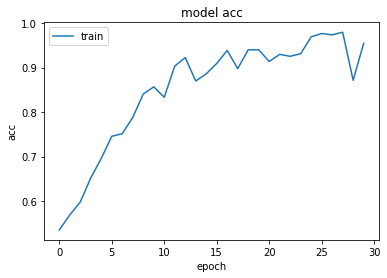

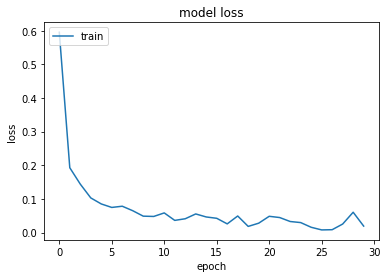

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/gdrive/My Drive/acc1.jpeg')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/gdrive/My Drive/loss1.jpeg')
plt.show()


## Defining gradcams

In [ ]:
#defining grad cam function
def grad_cam(image, mask ,cls ,model):
    """GradCAM method for visualizing input saliency."""
    epsilon = 1e-10
    y_c = model.output[0]
    conv_output = model.get_layer('pen_ultimate').output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([model.inputs], [conv_output, grads])

    output, grads_val = gradient_function([image ,mask])
    output, grads_val = output[0], grads_val[0]

    weights = np.mean(grads_val, axis=(0, 1))
    print('grad_val shape {} output {}'.format(grads_val.shape ,output.shape))
    cam = np.dot(output, weights)
    print(cam.shape)
    # Process CAM
    cam = cv2.resize(cam, (512 ,512), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    print(cam.max())
    cam = cam / (cam.max()+epsilon)
    return cam

## Plotting gradcams

[1.]
grad_val shape (6, 6, 512) output (6, 6, 512)
(6, 6)
0.0005770991
prediction:[[0.04219145]]
(512, 512, 3)


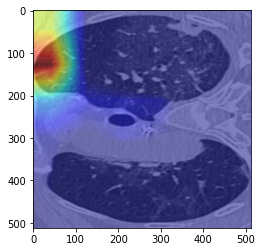

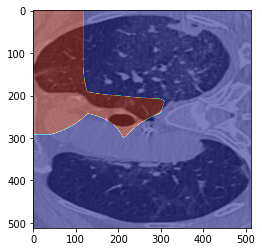

In [ ]:
i = random.choice([k for k in range(0 ,60)])
k = val_Y[i]
print(k)
mask = val_masks[i ,: ,: ,:].reshape((1 ,512 ,512 ,1))
cam = grad_cam(val_X[i ,: ,: ,:].reshape((1 ,512 ,512 ,3)) ,mask ,int(k) ,classifier)
print('prediction:{}'.format(classifier.predict([val_X[i ,: ,: ,:].reshape((1 ,512 ,512 ,3)) ,mask])))
print(val_X[i ,: ,: ,:].shape)
img = (((val_X[i ,: ,: ,:]/2)+0.5)*255).astype('uint8')
plt.imshow(img)
plt.imshow(cam.reshape(512 ,512) ,cmap = 'jet' ,alpha = 0.5)
plt.show()
ret, cam = cv2.threshold(cam, np.mean(cam), 1, cv2.THRESH_BINARY) 
plt.imshow(img.astype('uint8'))
plt.imshow(cam.reshape(512 ,512) ,cmap = 'jet' ,alpha = 0.5)
plt.show()

In [ ]:
pred = classifier.predict([val_X ,val_masks] ,verbose = 1).reshape(-1)
y_true = val_Y.reshape(-1)
y_pred = np.zeros_like(val_Y)
for i in range(pred.shape[0]):
    if pred[i] >= 0.5:
        y_pred[i] = 1

62/62 [==============================] - 5s 79ms/step


Accuracy: 0.693548
Precision: 0.937500
Recall: 0.454545
F1 score: 0.612245
ROC AUC: 0.710031
condusion matrix:[[28  1]
 [18 15]]


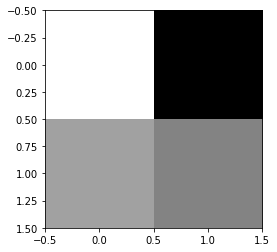

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_true ,y_pred)
print('Precision: %f' % precision)
recall = recall_score(y_true ,y_pred)
print('Recall: %f' % recall)
f1 = f1_score(y_true ,y_pred)
print('F1 score: %f' % f1)
auc = roc_auc_score(y_true ,y_pred)
print('ROC AUC: %f' % auc)
matrix = confusion_matrix(y_true ,y_pred)
print('condusion matrix:{}'.format(matrix))
plt.imshow(matrix ,cmap = 'gray')